In [1]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
%matplotlib inline

def csvread(filename='A.csv'):
    df = pandas.read_csv(filename) # df is pandas.DataFrame
    return df

#gpu sync problem
import tensorflow as tf
from keras.backend import tensorflow_backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
look_back = 1
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)
 
filename = 'E2 TextLog2.txt'
# file loader
df = pd.read_csv(filename,index_col='Timestamp') # df is pandas.DataFrame

id1 = df['ns=2;i=201732']
id2 = df['ns=2;i=201972']
id3 = df['ns=2;i=202672']
df.head
# convert nparray
nparr = df['ns=2;i=201732'].values[::-1]
nparr.astype('float32')
print(nparr)
print(id1[:3])

[6.754157 6.754157 6.754157 ... 6.754157 6.754157 6.754157]
Timestamp
2019/04/22 03:10:19.4951    6.754157
2019/04/22 03:10:19.9638    6.754157
2019/04/22 03:10:20.4638    6.754157
Name: ns=2;i=201732, dtype: float64


In [3]:
print(nparr.shape)
print(nparr[:3])
nparr = nparr.reshape(-1,1)
print(nparr.shape)
print(nparr[:3])

(1714,)
[6.754157 6.754157 6.754157]
(1714, 1)
[[6.754157]
 [6.754157]
 [6.754157]]


In [4]:
# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
nptf = scaler.fit_transform(nparr)
 
print(nptf)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


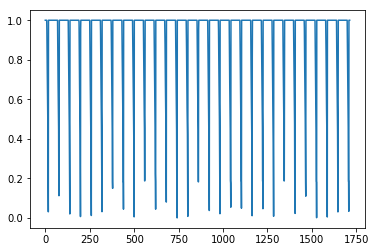

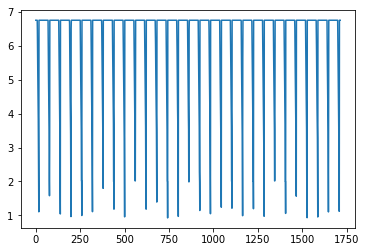

In [5]:
plt.plot(nptf)
plt.show()
plt.plot(nparr)
plt.show()

In [6]:
# split train, test
train_size = int(len(nptf) * 0.9)
test_size = len(nptf) - train_size
train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
print(len(train), len(test))
# create dataset for learning
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


1542 172


Train Score: 0.65 RMSE
Predict the Close value of final day: 6


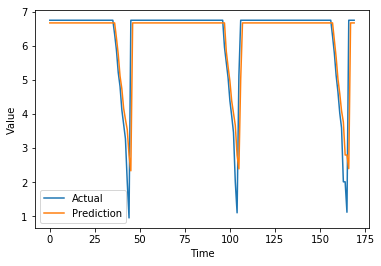

In [7]:
# simple lstm network learning
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
history = model.fit(trainX, trainY,validation_split=0.33, epochs=50, batch_size=8, verbose=0)
 
# make prediction
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % testScore)
 
# predict last value (or tomorrow?)
lastX = nptf[-1]
lastX = np.reshape(lastX, (1, 1, 1))
lastY = model.predict(lastX)
lastY = scaler.inverse_transform(lastY)
print('Predict the Close value of final day: %d' % lastY)  # 데이터 입력 마지막 다음날 종가 예측
 
plt.plot(testY,label= 'Actual')
plt.plot(testPredict,label='Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


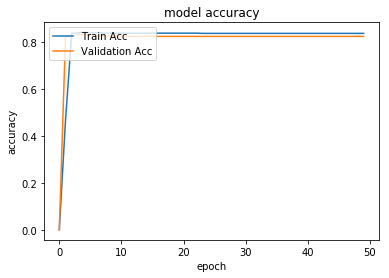

In [8]:
#summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Acc', 'Validation Acc'], loc='upper left')
plt.show()


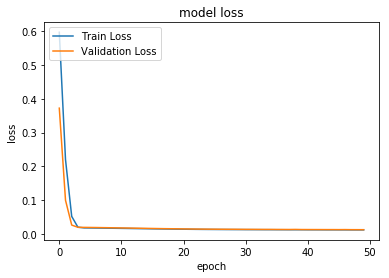

In [9]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
plt.show()